In [1]:
import textwrap

import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from rho_plus.util import spread as rho_spread
from rho_plus.color_util import contrast_with
import rho_plus as rp
from rho_plus.matplotlib_tweaks import *

IS_DARK = True
theme, cs = rp.mpl_setup(IS_DARK)
rp.panel_setup(IS_DARK)

dow = sns.load_dataset('dowjones')

<Axes: xlabel='Date', ylabel='Price'>

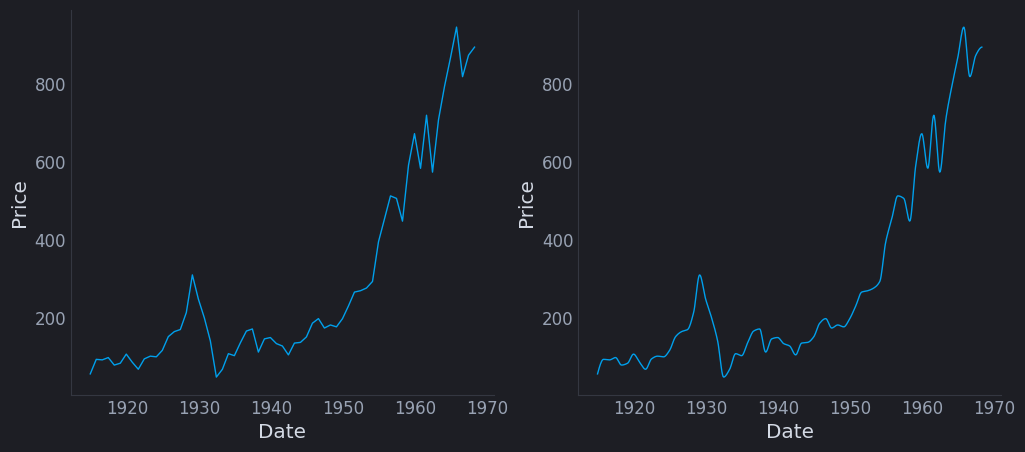

In [2]:
import scipy.interpolate as interp
import numpy as np

def smooth_straight_lines(ax=None, resample_factor=10):
    if ax is None:
        ax = plt.gca()

    for line in ax.lines:
        pts = ax.transData.inverted().transform(line.get_xydata())

        xx = np.linspace(pts[:, 0].min(), pts[:, 0].max(), len(pts) * resample_factor)
        spl = interp.PchipInterpolator(pts[:, 0], pts[:, 1])
        yy = spl(xx)

        new_x, new_y = ax.transData.transform(np.vstack([xx, yy]).T).T

        line.set_xdata(new_x)
        line.set_ydata(new_y)

    return ax

subs = dow.iloc[::10]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
sns.lineplot(subs, x='Date', y='Price', lw=1, ax=ax1)
sns.lineplot(subs, x='Date', y='Price', lw=1, ax=ax2)
smooth_straight_lines()

2.0 5


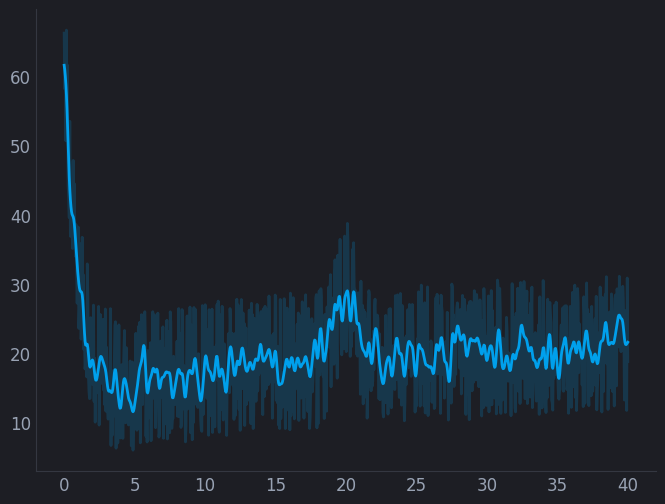

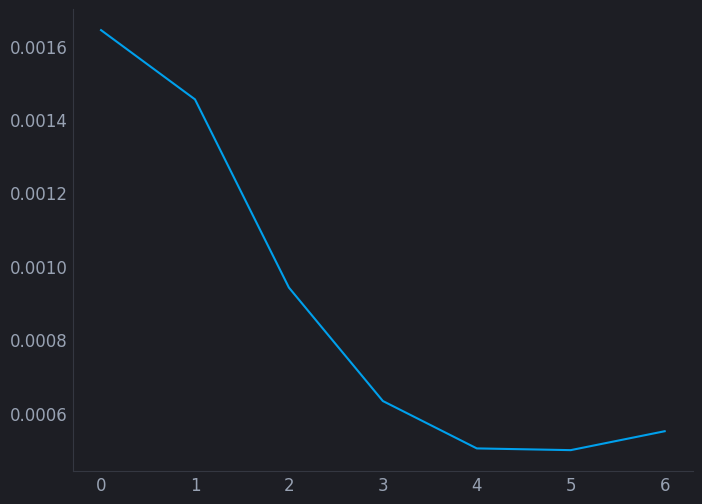

In [703]:
import scipy.interpolate as interp
from scipy.optimize import minimize_scalar
import numpy as np
from copy import deepcopy
from scipy.integrate import simpson

def overlap_area(pts, lw=1.5, dpi=plt.rcParams['figure.dpi']):
    # get times where the line doubles back on itself
    # double_back_inds = np.where(np.diff(np.sign(np.diff(pts[:, 1]))) > 0)[0]

    # just use all the angles, actually
    double_back_inds = np.arange(0, len(pts) - 2)
    # get triangles corresponding to those jumps
    abcs = pts[double_back_inds.reshape(-1, 1) + np.arange(3), :]
    # normalize so b = 0, doesn't affect anything
    abcs -= abcs[:, [1], :]
    # flip so it's up-down-up and not down-up-down
    # abcs[:, :, 1] *= np.sign(abcs[:, 0, 1]).reshape(-1, 1)
    # overlaps can only exist where both lines are
    # abcs[:, :, [1]] = np.clip(abcs[:, :, [1]], -np.inf, np.median(abcs[:, :, [1]], axis=1, keepdims=True))


    areas = np.abs(np.cross(abcs[:, 2], abcs[:, 0])) / 2
    a_angles = np.arctan2(abcs[:, 0, 1], abcs[:, 0, 0])
    c_angles = np.arctan2(abcs[:, 2, 1], abcs[:, 2, 0])
    angle_between = np.abs(a_angles - c_angles) / 2
    lw_pix = lw / 2  # we want 'radius', not 'diameter'
    lw_pix /= 72  # convert from points to inches
    lw_pix *= dpi  # convert from inches to pixels
    overlap_areas = lw_pix * (lw_pix / np.abs(np.tan(angle_between)))
    overlap_pct = (overlap_areas / areas).clip(0, 1)
    # curve = np.abs(np.diff(interp.CubicSpline(pts[:, 0], pts[:, 1]).derivative()(pts[:, 0]))).mean()
    return overlap_pct.mean()

def convolve_kaiser(pts, M, beta):
    xx = pts[:, 0]
    window = np.kaiser(M, beta)
    window /= np.sum(window)
    pad_start = (M - 1) // 2
    pad_end = (M - 1) // 2
    yy = np.convolve(np.pad(pts[:, 1], (pad_start, pad_end), 'edge'), window, mode='valid')
    return np.vstack([xx, yy]).T

def smooth_noisy_lines(ax=None, smoothness=0.5, keep_old_line=True, debug=False, beta=None, wl=None, max_times=50):
    """
    Applies a moving average to smooth out data. ax is the axis on which to do so, defaults to plt.gca().

    Great care has been taken to make the defaults effective: no fiddling should be required.

    If you do need to fiddle:

    smoothness ranges between 0 and 1, and controls the effective scale of the window
    """
    if ax is None:
        ax = plt.gca()

    if smoothness == 0:
        # do nothing
        return ax

    if smoothness < 0 or smoothness > 1:
        raise ValueError('Smoothness must be between 0 and 1')

    for line in ax.lines:
        pts = line.get_transform().transform(line.get_xydata())

        if len(pts) <= 5:
            # no need to smooth small lines
            continue

        @np.vectorize
        def score_params(beta, window_len):
            """Get the overlap percentage for the choice of β."""
            return overlap_area(convolve_kaiser(pts, window_len, beta), line.get_linewidth(), ax.figure.get_dpi())


        wls = np.arange(3, len(pts) - (len(pts) % 2) - 1, 2)
        wls = wls[2 ** np.arange(1, int(np.log2(len(wls))) + 1) - 1]

        bb = 2 ** np.linspace(1, 6, 25)
        best_params = (14, 3)
        best_score = 10000
        for wl in wls[::-1]:
            scores = score_params(bb, wl)
            argmin = np.argmin(scores)
            if (scores[argmin] - best_score) <= 1e-3:
                best_score = scores[argmin]
                best_params = (bb[argmin], wl)

        beta_star, wl_star = best_params
        print(beta_star, wl_star)


        if debug:
            plt.show()
            for wl, color in zip(wls, sns.color_palette('rho_sequential', len(wls))):
                scores = score_params(bb, wl)
                plt.plot(bb, scores, label=str(wl), color=color)
            plt.ylabel('{:.2f}'.format(score_params(0.5, 3)))
            rp.line_labels()
            plt.show()


        wl_star = max(7, int(round(0.02 * len(pts))))
        if wl is not None:
            wl_star = wl

        if wl_star % 2 == 0:
            wl_star -= 1

        if wl_star == 1:
            return ax

        if beta is not None:
            beta_star = beta


        scores = []
        prev_score = 100
        curr_pts = pts
        curr_score = overlap_area(curr_pts, line.get_linewidth(), ax.figure.get_dpi())
        beta_star = 14
        while (prev_score - curr_score) >= 1e-3 * abs(prev_score) and len(scores) < max_times:
            scores.append(curr_score)
            prev_score = curr_score
            new_pts = convolve_kaiser(curr_pts, wl_star, beta_star)
            curr_score = overlap_area(new_pts, line.get_linewidth(), ax.figure.get_dpi())
            if curr_score < prev_score:
                curr_pts = new_pts
            wl_star += 2
            wl_star = min(wl_star, len(pts) - 3 - (len(pts) % 2))
            beta_star *= 1

        scores.append(curr_score)

        # new_x, new_y = line.get_transform().inverted().transform(convolve_kaiser(pts, wl_star, beta_star)).T
        new_x, new_y = line.get_transform().inverted().transform(curr_pts).T

        if keep_old_line:
            # set alpha low a la Tensorboard
            new_line = mpl.lines.Line2D(new_x, new_y)
            new_line.update_from(line)
            ax.add_line(new_line)
            line.set_alpha(0.2)
        else:
            line.set_xdata(new_x)
            line.set_ydata(new_y)

    return scores

np.random.seed(129)
loss_xx = np.linspace(0, 40, 1000)
loss_yy = np.exp(4 - loss_xx) + 0.2 + np.log(loss_xx + 1) * 3
loss_yy += np.exp(-1 * (20 - loss_xx) ** 2) * 10
loss_yy += np.random.random(len(loss_xx)) * 20

fig, ax = plt.subplots()
ax.plot(loss_xx, loss_yy, lw=2)
scores = smooth_noisy_lines(ax)
plt.show()
plt.plot(scores)

# fig, ax = plt.subplots()
# ax.plot(loss_xx, loss_yy, lw=1.5)
# smooth_noisy_lines(ax, keep_old_line=True, debug=True)

# import pandas as pd

# M, O = np.meshgrid(
#     [0.1, 0.3, 0.5, 0.7, 0.9],
#     [0.1, 0.3, 0.5, 0.7, 0.9]
# )
# opts_df = pd.DataFrame({
#     'locality': M.flatten(),
#     'smoothness': O.flatten(),
# })

# with sns.plotting_context('paper'):
#     g = sns.FacetGrid(opts_df, row='locality', col='smoothness', height=2, aspect=1.5)

#     def plot_values(data, **kwargs):
#         m = data['locality'].values[0]
#         o = data['smoothness'].values[0]

#         ax = plt.gca()
#         ax.plot(loss_xx, loss_yy, lw=0.5)
#         smooth_noisy_lines(ax=plt.gca(), smoothness=o, locality=m, keep_old_line=True)

#     g.map_dataframe(plot_values)
#     g.set_titles('{col_var} = {col_name}\n{row_var} = {row_name}')

In [531]:
# https://www.geogebra.org/calculator/txd48atz
# we're getting the amount of overlap between the lines, as a proportion of the total area
# a good plot shouldn't have all the lines on top of each other

pts = l.get_transform().transform(l.get_xydata())

def overlap_pct(pts):
    # get times where the line doubles back on itself
    # double_back_inds = np.where(np.diff(np.sign(np.diff(pts[:, 1]))) > 0)[0]

    # just use all the angles, actually
    double_back_inds = np.arange(0, len(pts) - 2)
    # get triangles corresponding to those jumps
    abcs = pts[double_back_inds.reshape(-1, 1) + np.arange(3), :]
    # normalize so b = 0, doesn't affect anything
    abcs -= abcs[:, [1], :]
    # flip so it's up-down-up and not down-up-down
    # abcs[:, :, 1] *= np.sign(abcs[:, 0, 1]).reshape(-1, 1)
    # overlaps can only exist where both lines are
    # abcs[:, :, [1]] = np.clip(abcs[:, :, [1]], -np.inf, np.median(abcs[:, :, [1]], axis=1, keepdims=True))


    areas = np.abs(np.cross(abcs[:, 2], abcs[:, 0])) / 2
    a_angles = np.arctan2(abcs[:, 0, 1], abcs[:, 0, 0])
    c_angles = np.arctan2(abcs[:, 2, 1], abcs[:, 2, 0])
    angle_between = np.abs(a_angles - c_angles) / 2
    lw = 0.5
    overlap_areas = lw * (lw / np.abs(np.tan(angle_between)))
    return np.nan_to_num(overlap_areas / areas, posinf=0).clip(None, 1).mean()

# overlap_pct(np.vstack([[0, 1, 2], [2, 2, 2]]).T)
# overlap_pct(np.vstack([[0, 1, 1], [2, 2, 1]]).T)
orig_pct = overlap_pct(pts)

pcts = []

def score_beta(beta):
    xx = pts[:, 0]
    M = min(11, len(pts) - (len(pts) % 2))
    window = np.kaiser(M, beta)
    window /= np.sum(window)
    pad_start = (M - 1) // 2
    pad_end = (M - 1) // 2
    yy = np.convolve(np.pad(pts[:, 1], (pad_start, pad_end), 'edge'), window, mode='valid')

    return overlap_pct(np.vstack([xx, yy]).T)


In [482]:
beta_spl.derivative().roots()

array([ 0.1       , 28.98947368, 50.        ])

In [58]:
beta = 14
xx = pts[:, 0]
M = min(11, len(pts) - (len(pts) % 2))
window = np.kaiser(M, beta)
window /= np.sum(window)
pad_start = (M - 1) // 2
pad_end = (M - 1) // 2
yy = np.convolve(np.pad(pts[:, 1], (pad_start, pad_end), 'edge'), window, mode='valid')

def grouped_kurtosis(data, groups=10):
    return kurtosis(data[:len(data)-(len(data)%groups)].reshape(-1, groups))

print(grouped_kurtosis(pts))
print(grouped_kurtosis(yy))

[-1.20024002  6.98831344 -1.20024002  9.7282895  -1.20024002  6.02830556
 -1.20024002  9.94933893 -1.20024002  3.27564821]
[ 6.75880665  8.85384906 10.70400407 11.12983579 12.97206223 18.83616384
 23.77158891 23.13166935 16.73392784 10.36782548]


In [16]:
kurtosis(pts[:-(len(pts)%groups)].reshape(-1, groups))

array([], dtype=float64)

In [21]:
kurtosis(pts[:len(pts)-(len(pts)%groups)].reshape(-1, groups))

array([-1.20024002, 40.55209814, -1.20024002, 42.28052444, -1.20024002,
       25.55973076, -1.20024002, 38.09343952, -1.20024002, 31.73253656])

In [ ]:
kurtosis(pts[:len(pts)-(len(pts)%groups)].reshape(-1, groups))